In [43]:
%load_ext autoreload
%autoreload 2
from newton import LogisticRegression, NewtonOptimizer, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<font size= "6"> Abstract: </font>

In our past blog posts we explored perceptrons and implemented them in various capacities. Then we took the next step and in the following blog post we implemented Logistic Regression with Gradient Descent Optimization. Now we are piggy backing off the code base of our "Implementing Logistic Regression" post in order to investigate other optimization methods other than gradient descent. Below we explain how we implemented the code for our optimizer, exhibit its traditional use, highlight how it can perform better or worse than gradient descent depending on the data set, and quantitatively how different data sets affect the performance.


I have attached below a link to my source code for the LogisticRegression and NewtonOptimizer classes. 

https://github.com/Astro2024/Astro2024.github.io/blob/main/posts/newtons-method/newton.py

<font size="6"> Part A: Implement NewtonOptimizer </font>

<font size="5"> LogisticRegression Class: </font>

<font size="4"> Sigma: </font> In order to implement our Logistic Regression model I first started by defining a function called sigma. This function allows our gradient decent to find a global minimum for the loss function.

In [235]:
import torch
def sigma(self, val):
     return 1 / (1 + torch.exp(-val))

<font size="4"> Loss: </font> After implementing the sigma function I created our loss function based off the equation 

$L(w) = \frac{1}{n} \sum_{i=1}^{n} [-y_i log(\sigma(s_i)) - (1 - y_i)log(1 - \sigma(s_i))]$.
Where our $s_i$ is the predicted score at a given index and $\sigma$ is the function defined above.

In [236]:
def loss(self, X, y):
     s = self.score(X)
     inner = (-1*y*torch.log(self.sigma(s))) - ((1 - y) *torch.log(1- self.sigma(s)))
     return (1/X.shape[0]) * inner.sum()

<font size="4"> Grad: </font> The mathematical equation for this function is the same as our last blog post, 

$L(w) = \frac{1}{n} \sum_{i=1}^{n} (\sigma(s_i) - y_i)x_i$. In the code below we take advantage of linear algebra operation to eliminate explicit sum functions.

In [237]:
def grad(self, X, y):
    s = self.score(X)
    summation = (self.sigma(s) - y)@X
    return (1/X.shape[0]) * summation

<font size="4"> Hessian: </font> Unlike our last blog post we have one more function we must define in our LogisticRegression class that computes the hessian matrix of the loss function. The mathematical equation for this function is $H(w) = X^T D(w) X$ where $D$ is the diagonal matrix with entries $d_{kk}(w) = \sigma(s_k) (1 - \sigma(s_k))$.

In [ ]:
def hessian(self, X):
    s = self.score(X)
    tran_X = X.T
    d = torch.diag_embed(self.sigma(s) * (1 - self.sigma(s)))
    return tran_X@d@X

<font size="5"> GradientDescentOptimizer Class: </font>

<font size="4"> Step: </font> This function computes one step of the Logistic Regression update using the feature matrix X and target vector y. The mathematical equation for the update is, $w \leftarrow w - \alpha H(w)^{-1} \triangledown L(w)$. Where $\alpha$ is our designated learning rate.

In [239]:
def step(self, X, y, alpha):
        new_w = alpha*torch.inverse(self.model.hessian(X))@self.model.grad(X,y)
        self.model.w -= new_w

<font size="6"> Part B: Experiments </font>

The following block of code defines a function that generates random data we will use for data classification. Using this function we can choose the number of data point, how many dimensions each data point has, and how "noisy" the data is (how easily separable it is).

In [36]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise=.2)

<font size="4"> Tradition Newton's Method: </font>

The following code is an example of why we use Newton's method optimization. Using linearly separable 2 dimensional data, and a sufficiently low alpha we can observe that our loss function is monotonically decreasing and looks like it is converging towards 0. This means as we do further iteration and optimization our loss will continue to get lower until it converges to a minimum loss.

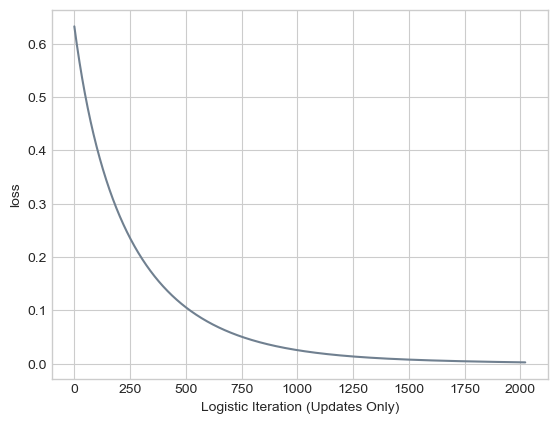

In [41]:
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

loss = 1.0
count = 0
# for keeping track of loss values
loss_vec = []

while loss > .001 and count < 5000:
    count += 1
    #Calculate loss and record improvement
    loss = LR.loss(X, y) 
    loss_vec.append(loss)

    #Update LR 
    opt.step(X, y, alpha = 1)

#Plots the progress of our loss through optimization
plt.plot(loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Logistic Iteration (Updates Only)", ylabel = "loss")


<font size="4"> Benefits of Newton vs Gradient: </font> Since both Newton's Method of Optimization and Gradient Descent Optimization are used in conjunction with our Logistic Regression class it is fair to wonder whether one method of optimization is more efficient than the other. In the code below I have trained three separate models on the same data. The first model is using Vanilla Gradient Descent Optimization ($\beta = 0$). The second model uses Gradient Descent Optimization with momentum ($\beta = 0.8$). The third and final model uses Newton's Optimization. As we see in the example below, if the size of the data is relatively low then the third model converges the fastest. However, I did observe that if the number of data points is raised significantly that Newton's method starts to converge much later than gradient descent using the same learning rate.


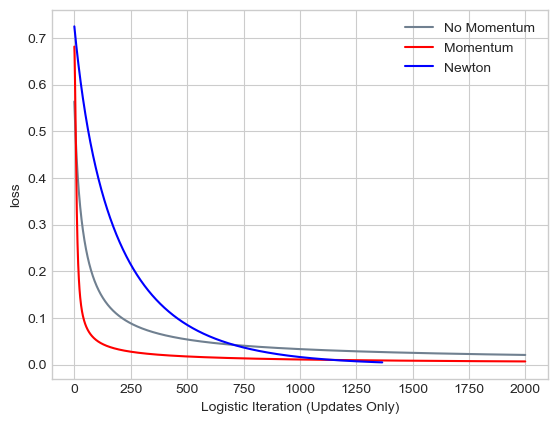

In [97]:
X, y = classification_data(n_points=50, noise=.25, p_dims=2)
#Initialize two Logistic Regression functions
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)
LR1 = LogisticRegression() 
opt1 = GradientDescentOptimizer(LR1)
LR2 = LogisticRegression() 
opt2 = NewtonOptimizer(LR2)
#Initialize lass for two functions
loss = 1.0
loss_vec = []
loss1 = 1.0
loss_vec1 = []
loss2 = 1.0
loss_vec2 = []
count = 0

#Iterate until the momentum model is under threshold
while count < 2000:
    count += 1
    #Calculate and record losses
    loss = LR.loss(X, y) 
    loss_vec.append(loss)
    loss1 = LR1.loss(X, y) 
    loss_vec1.append(loss1)
    loss2 = LR2.loss(X, y) 
    loss_vec2.append(loss2)

    # Optimize model 1 with no momentum, and model 2 with momentum
    opt.step(X, y, alpha = 0.2, beta = 0)
    opt1.step(X, y, alpha = 0.2, beta = .8)
    opt2.step(X, y, alpha = 0.2)

#Plots the progress of our loss through optimization
plt.plot(loss_vec, color = "slategrey", label="No Momentum")
plt.plot(loss_vec1, color = "red", label="Momentum")
plt.plot(loss_vec2, color = "blue", label="Newton")
plt.legend()
labs = plt.gca().set(xlabel = "Logistic Iteration (Updates Only)", ylabel = "loss")

<font size="4"> Inappropriate learning rate: </font> There are a few things we must be wary of while using Newton's method of optimization. As I stated above, the larger the data set the slower Newton's method converges, however, if we just also increase $\alpha$ along with the size of the data, then we will continue to converge very quickly. But there is a risk to increasing the learning rate too much. Below is an example where an extremely high learning rate can cause the loss function to diverge. 

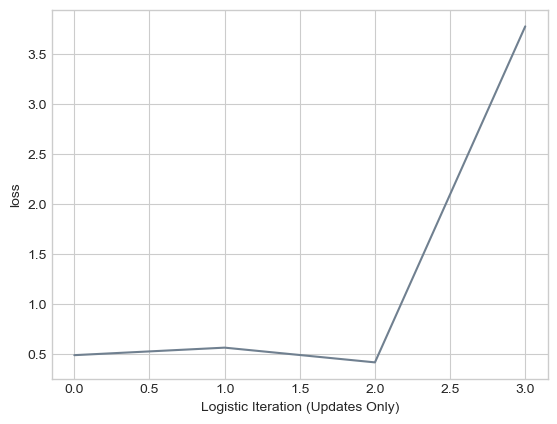

In [94]:
X, y = classification_data(n_points=50, noise=.5, p_dims=10)
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

loss = 1.0
count = 0
# for keeping track of loss values
loss_vec = []

while loss > .001 and count < 5000:
    count += 1
    #Calculate loss and record improvement
    loss = LR.loss(X, y) 
    loss_vec.append(loss)

    #Update LR 
    opt.step(X, y, alpha = 70)

#Plots the progress of our loss through optimization
plt.plot(loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Logistic Iteration (Updates Only)", ylabel = "loss")


<font size= "6"> Part C: Operation Counting </font>

Assuming that it costs $c$ computational units to compute the loss $L$, $2c$ units to compute the gradient $\triangledown L$, $pc$ units to compute the Hessian, $k_1 p^\gamma$ units to invert a $p x p$ matrix and $k_2 p^2$ units to perform the matrix-vector multiplication required by Newton’s method. Then the time complexity of Newton's method is $O(t_{nm}(3c + pc + k_1 p^\gamma + k_2 p^2))$ and gradient descent is $O(t_{gd} 3c)$. Therefore, in order for Newton's method to take fewer computational steps than gradient descent $t_{nm} \leq t_{gd} (\frac{3c}{3c + pc + k_1 p^\gamma + k_2 p^2})$. Since all of the variable other than $p$ are constants as $p \to \infty$, $t_{nm} \leq t_{gd} (\frac{3c}{3c + pc + k_1 p^\gamma + k_2 p^2}) \to t_{nm} \leq t_{gd} (0) \implies t_{nm} \leq 0$. So as $p$ becomes very large using Newton's method will never pay off.



<font size= "6"> Conclusion: </font>

As I mentioned at the beginning of this post we hoped to implement and explore a form of optimization separate to gradient descent, and that we have done. We have shown that Newton's method of optimization is successful in converging to the minimum loss. We have also showed where is outperforms (small data) and underperforms (large data/large $\alpha$). Lastly, we showed that as our set of features grows in size Newton's method must, at worst, converge at an inverse cubic rate in order to perform fewer computations. So, my largest take away is that if you have a sufficiently large data set I would recommend using gradient descent over Newton, however in most smaller examples the difference is not significant enough to warrant the use of one over the other.

